In [718]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
# import matplotlib.
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../../data/daily_sunspots_time_series_1850-01_2024-05.csv')

In [719]:
data = df[["counts"]]
# data['date'] = pd.to_datetime(data['date'])
data

,counts
0,253
1,162
2,217
3,99
4,108
...,...
63668,141
63669,139
63670,119
63671,100


In [720]:
train = data.iloc[:-50]
test = data.iloc[-50:]

train.shape
test.shape


(50, 1)

In [721]:
train.head()

,counts
0,253
1,162
2,217
3,99
4,108


Use fourier transform to use periodicity, here i have used a approx value.

In [722]:
11*365

4015

In [723]:
from scipy.signal import savgol_filter

In [724]:
train['data_filter'] = savgol_filter(train['counts'], 5, 2) # window size 51, polynomial order 3
train

,counts,data_filter
0,253,242.257143
1,162,201.171429
2,217,163.942857
3,99,128.228571
4,108,125.228571
...,...,...
63618,97,99.057143
63619,102,100.114286
63620,95,92.771429
63621,77,84.085714


<Axes: >

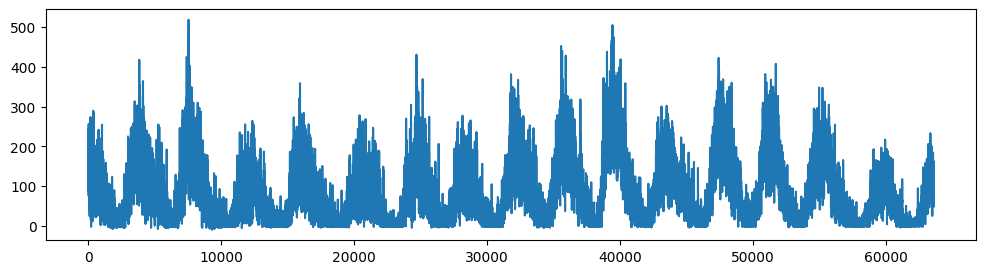

In [725]:
# train['log_counts'].plot()
train['data_filter'].plot()

<Axes: >

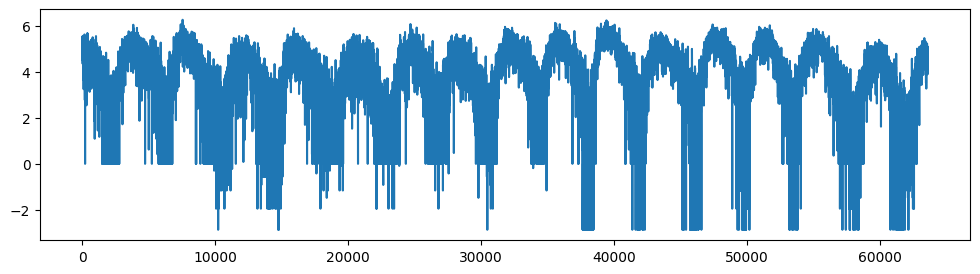

In [726]:
train['data_log_filter'] = np.log1p(train['data_filter'])
train['data_log_filter']= train['data_log_filter'].fillna(0)

train['data_log_filter'].plot()

In [727]:
# train[trend]

In [728]:
# train['log_counts'] = np.log1p(train['counts'])
train['timestep'] = list(range(train.shape[0]))
train['year_timestep'] = (train['timestep']//365)
train['sc_daytimestep'] = (train['timestep']//4015)

train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep
0,253,242.257143,5.494119,0,0,0
1,162,201.171429,5.309116,1,0,0
2,217,163.942857,5.105599,2,0,0
3,99,128.228571,4.861583,3,0,0
4,108,125.228571,4.838094,4,0,0
...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15
63619,102,100.114286,4.616251,63619,174,15
63620,95,92.771429,4.540860,63620,174,15
63621,77,84.085714,4.443659,63621,174,15


In [729]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63623 entries, 0 to 63622
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   counts           63623 non-null  int64  
 1   data_filter      63623 non-null  float64
 2   data_log_filter  63623 non-null  float64
 3   timestep         63623 non-null  int64  
 4   year_timestep    63623 non-null  int64  
 5   sc_daytimestep   63623 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 2.9 MB


<Axes: xlabel='year_timestep', ylabel='data_log_filter'>

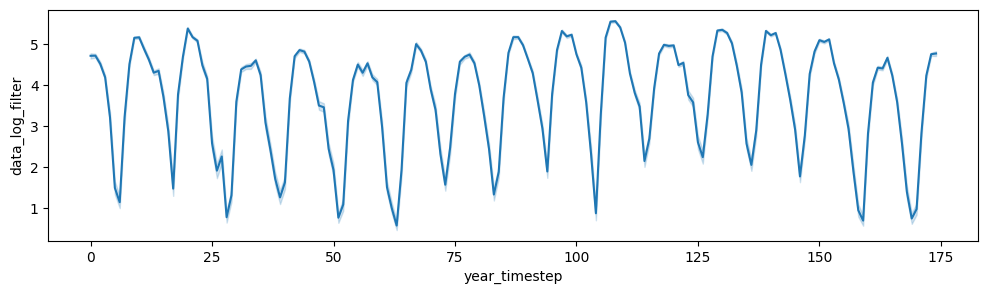

In [730]:
# train.plot()

# sns.lineplot(x = train['timestep'], y = train['data_log_filter'])
sns.lineplot(x = train['year_timestep'], y = train['data_log_filter'])

# sns.lineplot(x = train['sc_daytimestep'], y = train['data_log_filter'])
# sns.lineplot(x = train['sc_daytimestep'] , y = train['log_counts'])

Model

In [731]:
train.head()

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep
0,253,242.257143,5.494119,0,0,0
1,162,201.171429,5.309116,1,0,0
2,217,163.942857,5.105599,2,0,0
3,99,128.228571,4.861583,3,0,0
4,108,125.228571,4.838094,4,0,0


In [732]:
# train.set_index(train['date'], inplace = True)

In [733]:
# train.drop('date', axis=1)

Baseline Model

In [734]:
X_trend = train[['timestep','year_timestep','sc_daytimestep']]
y_trend = train['data_log_filter']

In [735]:
# check = train[train['data_log_filter'].isnull()]
# check

In [736]:
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import matplotlib as mpl
import seaborn as sns

trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [737]:
train['trend'] = trend_model.predict(X_trend)
train['trend']

0        5.864420
1        5.863551
2        5.862678
3        5.861800
4        5.860918
           ...   
63618    4.848740
63619    4.850637
63620    4.852531
63621    4.854420
63622    4.856304
Name: trend, Length: 63623, dtype: float64

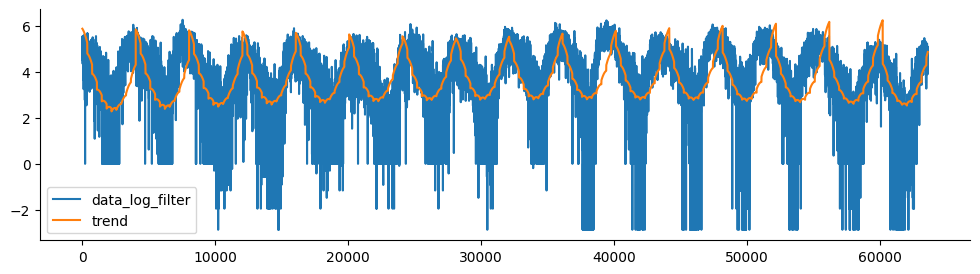

In [738]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['data_log_filter','trend']].plot(legend=True)
sns.despine()

**detrended data**

In [739]:
train['detrended'] = train['data_log_filter'] - train['trend']
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824
...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761


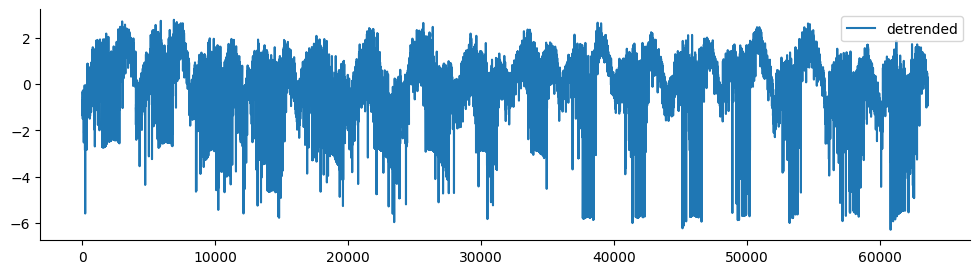

In [740]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

In [741]:
np.fft.rfft(train['detrended'])

array([-2.33493296e-08+0.00000000e+00j,  2.03603300e+02+9.06911122e+03j,
        8.69373720e+02-9.40595991e+03j, ...,
       -6.64214921e+01-4.18349668e+00j,  5.36898620e+01-2.95514911e-01j,
       -3.15605830e+01+1.60536829e+02j])

In [742]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt
# import seaborn as sns

# seas_decomp_check = seasonal_decompose(
#     x=train['detrended'], 
#     model='additive', 
#     # two_sided=True,
#     period= 365)


# # Plots:
# fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

# cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
# sns_c = sns.color_palette(palette=cmaps_hex)


# #Plot Signal
# ax[0].set(title='Observed data (signal)', 
#           ylabel=r'$^\circ$C')
# seas_decomp_check.observed.plot(color=sns_c[0], 
#                               linewidth=1,
#                               sharex=True,
#                               ax=ax[0])
# #Plot Trend
# ax[1].set(title='Trend (364 days moving average)', 
#           ylabel=r'$^\circ$C')
# seas_decomp_check.trend.plot(color=sns_c[1], 
#                               linewidth=1,
#                               sharex=True,
#                               ax=ax[1])
# #Plot Seasonality
# ax[2].set(title='Seasonality', 
#           ylabel=r'$^\circ$C')
# seas_decomp_check.seasonal.plot(
#                                 color=sns_c[2], 
#                                 linewidth=1,
#                                 sharex=True,
#                                 ax=ax[2])
# #Plot residual
# ax[3].set(title='Residual', 
#           ylabel=r'$^\circ$C');
# ax[3].scatter(
#     x=seas_decomp_check.resid.index,
#     y=seas_decomp_check.resid,
#     color=sns_c[3],
#     s=4)

# for i in range(4):
#     ax[i].set_xlim(pd.to_datetime("1850"),pd.to_datetime("2024"))
    
# # fig.savefig("visualisations/Basel_Temp_TSA_decomp.png",dpi=300)

In [743]:
# train['month'] = train.index.month
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824
...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761


In [744]:
X_seasonality = train[['sc_daytimestep','year_timestep','timestep']]
y_seasonality = train['detrended']

seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [745]:
train['seasonality'] = seasonality_model.predict(X_seasonality)
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822
...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761


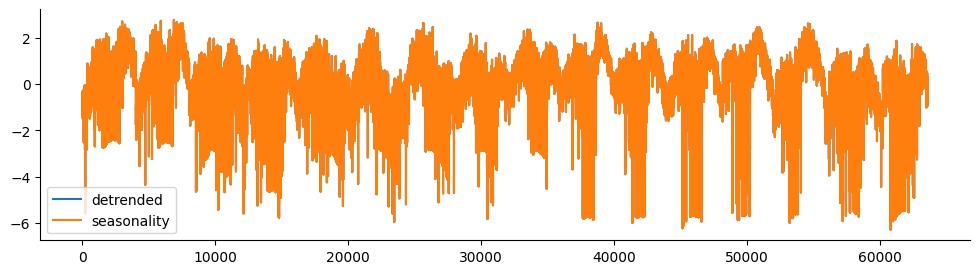

In [746]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

In [747]:
# from qcd import qcd_variance as qcd_variance
# import numpy as np



In [748]:
# qcd = qcd_variance(train['counts'])

In [749]:
def qcd_variance(series,window=3979):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [750]:
qcd_variance(train['data_log_filter'])

quartile coefficient of dispersion: 0.197137


In [751]:
qcd_variance(train['detrended'])

quartile coefficient of dispersion: 0.133241


In [752]:
train


,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822
...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761


this is wrong because the qcd is 0.7 which considered as hign so we need to use multiplicative decomposition types or transform and use additive

In [753]:
train['trend_seasonal'] = train['trend'] + train['seasonality']

train['remainder'] = train['data_log_filter']-train['trend_seasonal']
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality,trend_seasonal,remainder
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300,5.494121,-1.778633e-06
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433,5.309118,-2.036972e-06
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077,5.105601,-2.036971e-06
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215,4.861585,-2.036974e-06
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822,4.838096,-2.036972e-06
...,...,...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998,4.605741,1.989172e-07
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386,4.616251,1.989152e-07
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671,4.540860,1.989152e-07
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761,4.443659,1.989149e-07


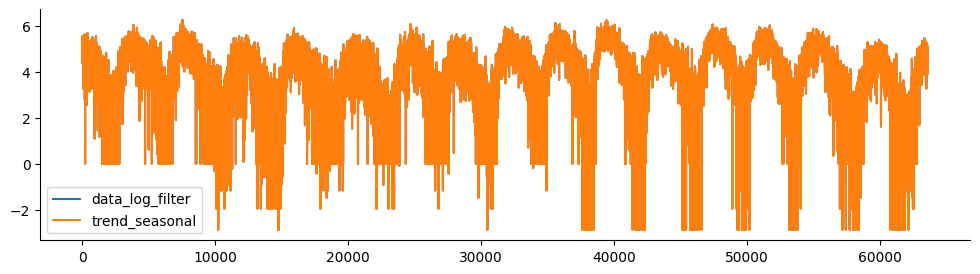

In [754]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['data_log_filter','trend_seasonal']].plot(legend=True)
sns.despine()

In [755]:
train['remainder'] = train['data_log_filter'] - train['trend_seasonal']

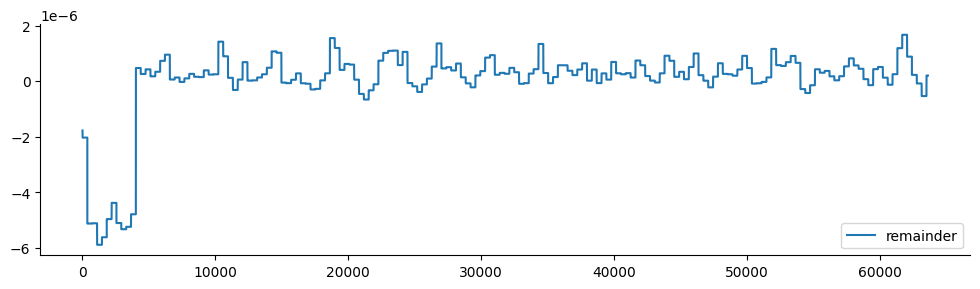

In [756]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

In [757]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.43369


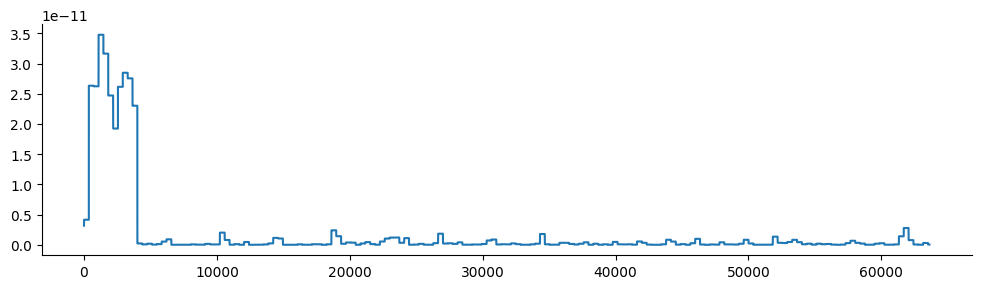

In [758]:
mpl.rc('figure',figsize=(12,3),dpi=100)
(train['remainder']**2).plot()
sns.despine()

In [759]:
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality,trend_seasonal,remainder
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300,5.494121,-1.778633e-06
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433,5.309118,-2.036972e-06
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077,5.105601,-2.036971e-06
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215,4.861585,-2.036974e-06
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822,4.838096,-2.036972e-06
...,...,...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998,4.605741,1.989172e-07
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386,4.616251,1.989152e-07
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671,4.540860,1.989152e-07
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761,4.443659,1.989149e-07


In [760]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [761]:
p = 3
df = create_lagged_features(train,p)
df
df_remainder = df.copy()
df_remainder

,remainder,lag_1,lag_2,lag_3
0,-1.778633e-06,NaN,NaN,NaN
1,-2.036972e-06,-1.778633e-06,NaN,NaN
2,-2.036971e-06,-2.036972e-06,-1.778633e-06,NaN
3,-2.036974e-06,-2.036971e-06,-2.036972e-06,-1.778633e-06
4,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036972e-06
...,...,...,...,...
63618,1.989172e-07,1.989155e-07,1.989166e-07,1.989115e-07
63619,1.989152e-07,1.989172e-07,1.989155e-07,1.989166e-07
63620,1.989152e-07,1.989152e-07,1.989172e-07,1.989155e-07
63621,1.989149e-07,1.989152e-07,1.989152e-07,1.989172e-07


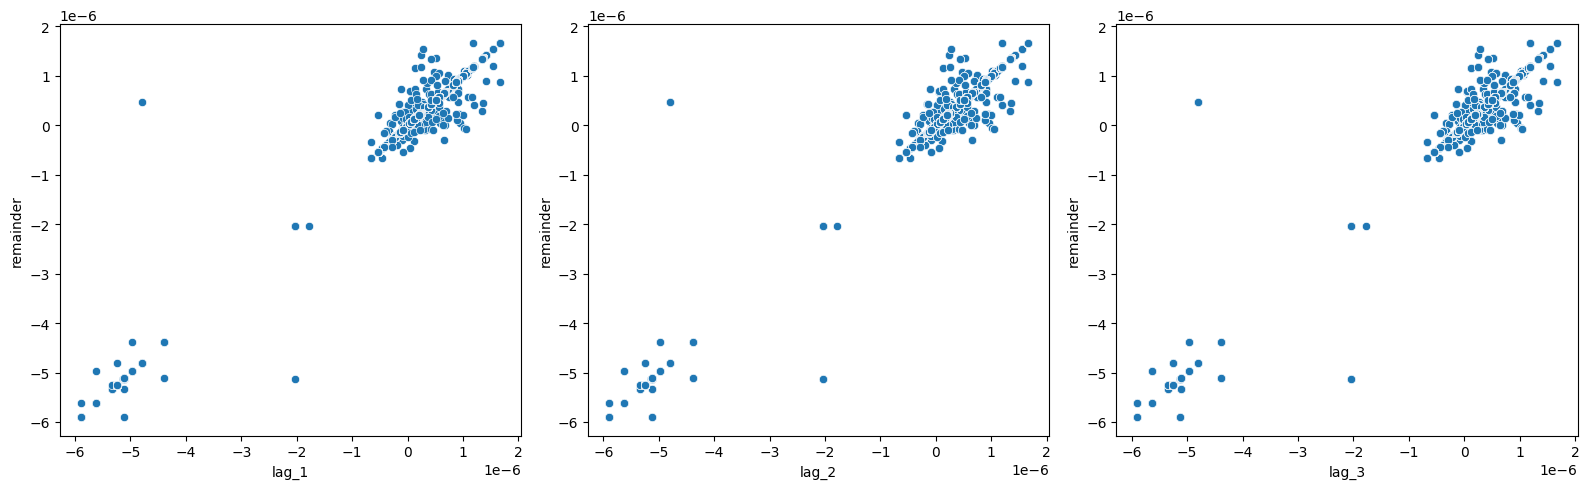

In [762]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(
        x=df[lag_columns[i]],
        y=df['remainder'],
        ax=axes[i]
    )
    
plt.tight_layout()

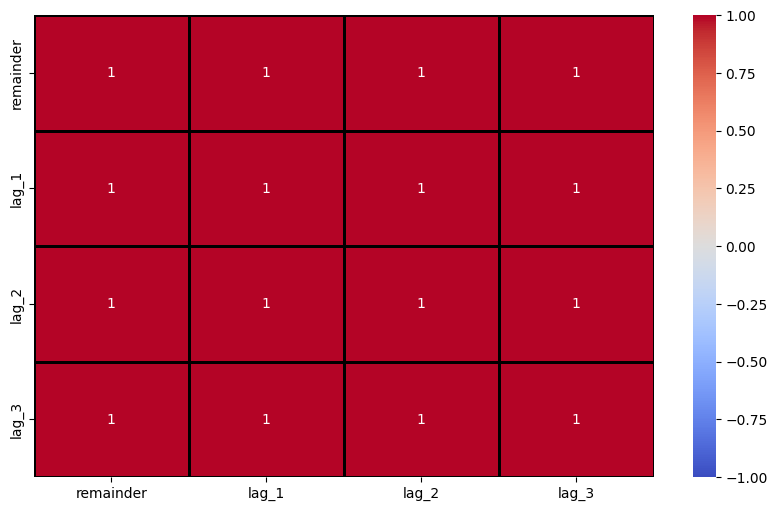

In [763]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

In [764]:
df.dropna(inplace=True)
df.head()

,remainder,lag_1,lag_2,lag_3
3,-0.000002,-0.000002,-0.000002,-0.000002
4,-0.000002,-0.000002,-0.000002,-0.000002
5,-0.000002,-0.000002,-0.000002,-0.000002
6,-0.000002,-0.000002,-0.000002,-0.000002
7,-0.000002,-0.000002,-0.000002,-0.000002


In [765]:
# feature and target for autoregression model

X_remainder = df.drop('remainder',axis=1)
y_remainder = df['remainder']

In [766]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [767]:
df['ar_predictions'] = ar_model.predict(X_remainder)

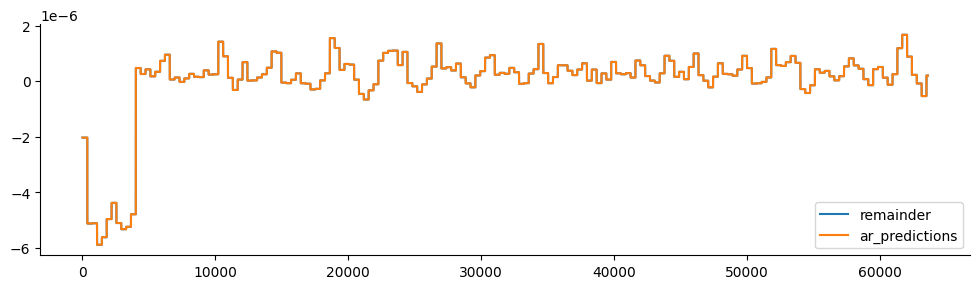

In [768]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','ar_predictions']].plot(legend=True)
sns.despine()

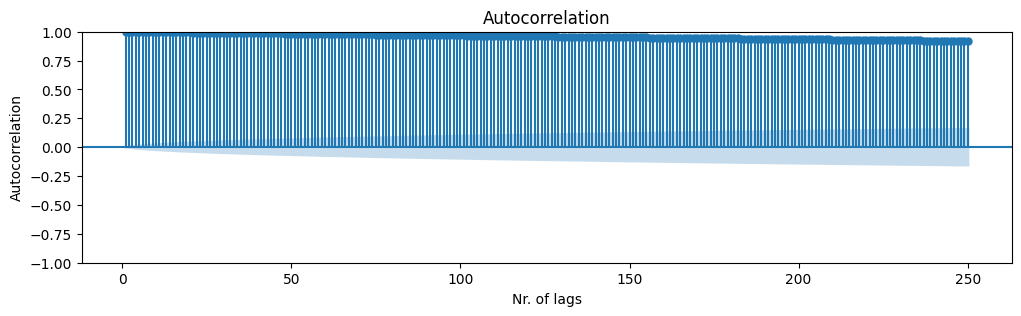

In [769]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.dpi"] = 100
plot_acf(df['remainder'],zero=False,lags=250)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

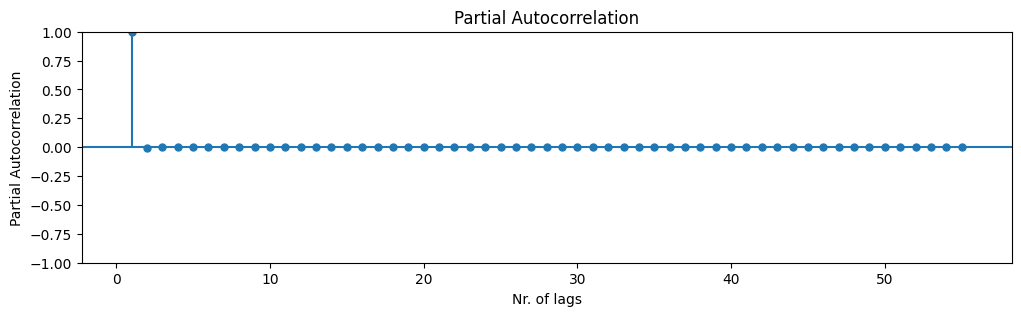

In [ ]:
plot_pacf(df_remainder['remainder'],zero=True,lags=55)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [771]:
df['residuals_ar'] = df['remainder'] - df['ar_predictions']

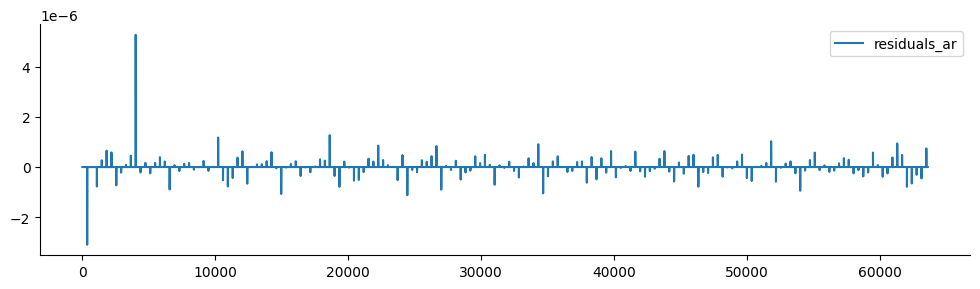

In [772]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['residuals_ar'].plot(legend=True)
sns.despine()

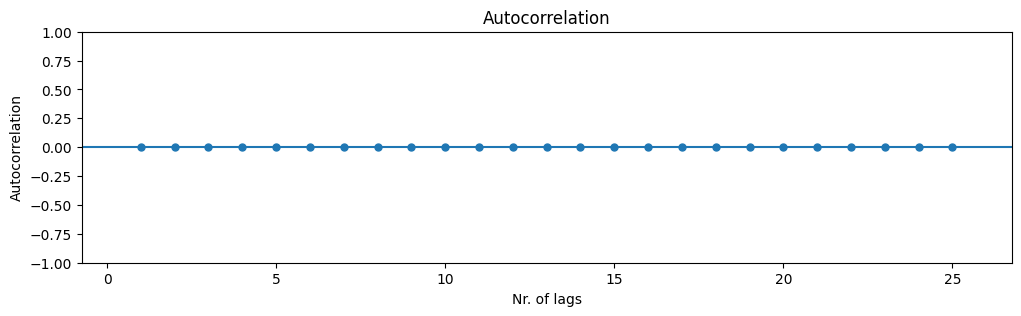

In [773]:
plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

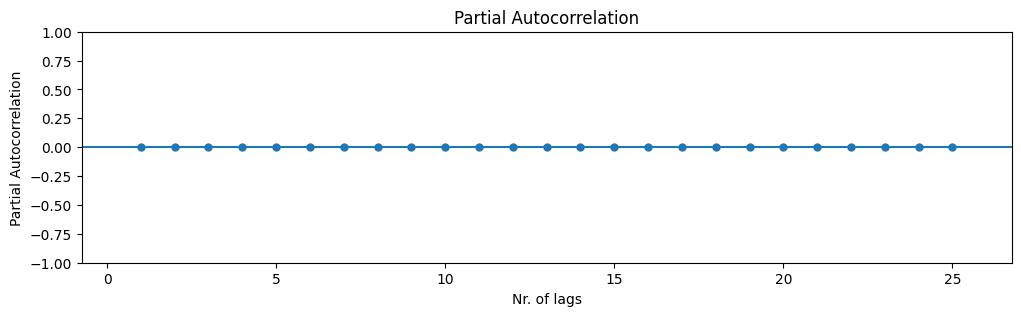

In [774]:
plot_pacf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [775]:
# df_remainder = df
df_remainder

,remainder,lag_1,lag_2,lag_3
0,-1.778633e-06,NaN,NaN,NaN
1,-2.036972e-06,-1.778633e-06,NaN,NaN
2,-2.036971e-06,-2.036972e-06,-1.778633e-06,NaN
3,-2.036974e-06,-2.036971e-06,-2.036972e-06,-1.778633e-06
4,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036972e-06
...,...,...,...,...
63618,1.989172e-07,1.989155e-07,1.989166e-07,1.989115e-07
63619,1.989152e-07,1.989172e-07,1.989155e-07,1.989166e-07
63620,1.989152e-07,1.989152e-07,1.989172e-07,1.989155e-07
63621,1.989149e-07,1.989152e-07,1.989152e-07,1.989172e-07


In [776]:
train

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality,trend_seasonal,remainder
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300,5.494121,-1.778633e-06
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433,5.309118,-2.036972e-06
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077,5.105601,-2.036971e-06
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215,4.861585,-2.036974e-06
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822,4.838096,-2.036972e-06
...,...,...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998,4.605741,1.989172e-07
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386,4.616251,1.989152e-07
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671,4.540860,1.989152e-07
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761,4.443659,1.989149e-07


In [777]:
df

,remainder,lag_1,lag_2,lag_3,ar_predictions,residuals_ar
3,-2.036974e-06,-2.036971e-06,-2.036972e-06,-1.778633e-06,-2.036320e-06,-6.534552e-10
4,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036972e-06,-2.036284e-06,-6.879778e-10
5,-2.036970e-06,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036282e-06,-6.871868e-10
6,-2.036972e-06,-2.036970e-06,-2.036972e-06,-2.036974e-06,-2.036280e-06,-6.924963e-10
7,-2.036973e-06,-2.036972e-06,-2.036970e-06,-2.036972e-06,-2.036283e-06,-6.906429e-10
...,...,...,...,...,...,...
63618,1.989172e-07,1.989155e-07,1.989166e-07,1.989115e-07,1.988868e-07,3.045913e-11
63619,1.989152e-07,1.989172e-07,1.989155e-07,1.989166e-07,1.988884e-07,2.674495e-11
63620,1.989152e-07,1.989152e-07,1.989172e-07,1.989155e-07,1.988864e-07,2.879080e-11
63621,1.989149e-07,1.989152e-07,1.989152e-07,1.989172e-07,1.988864e-07,2.845711e-11


In [778]:
df.drop('remainder',axis=1, inplace=True)
# train_target

In [779]:


train_target = train.join(df, how='left')
train_target.head(30)

,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3,ar_predictions,residuals_ar
0,253,242.257143,5.494119,0,0,0,5.864420,-0.370301,-0.370300,5.494121,-0.000002,NaN,NaN,NaN,NaN,NaN
1,162,201.171429,5.309116,1,0,0,5.863551,-0.554435,-0.554433,5.309118,-0.000002,NaN,NaN,NaN,NaN,NaN
2,217,163.942857,5.105599,2,0,0,5.862678,-0.757079,-0.757077,5.105601,-0.000002,NaN,NaN,NaN,NaN,NaN
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215,4.861585,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.534552e-10
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822,4.838096,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.879778e-10
5,203,169.314286,5.137645,5,0,0,5.860031,-0.722386,-0.722384,5.137648,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.871868e-10
6,142,147.228571,4.998755,6,0,0,5.859141,-0.860385,-0.860383,4.998758,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.924963e-10
7,76,90.142857,4.512428,7,0,0,5.858245,-1.345817,-1.345815,4.512430,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.906429e-10
8,95,88.657143,4.495993,8,0,0,5.857346,-1.361353,-1.361351,4.495995,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.913212e-10
9,124,125.714286,4.841935,9,0,0,5.856442,-1.014507,-1.014505,4.841937,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-6.902508e-10


In [780]:
train_target['total_predictions'] = train_target['trend_seasonal'] + train_target['ar_predictions']
train_target.dropna()


,counts,data_filter,data_log_filter,timestep,year_timestep,sc_daytimestep,trend,detrended,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3,ar_predictions,residuals_ar,total_predictions
3,99,128.228571,4.861583,3,0,0,5.861800,-1.000217,-1.000215,4.861585,-2.036974e-06,-2.036971e-06,-2.036972e-06,-1.778633e-06,-2.036320e-06,-6.534552e-10,4.861583
4,108,125.228571,4.838094,4,0,0,5.860918,-1.022824,-1.022822,4.838096,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036972e-06,-2.036284e-06,-6.879778e-10,4.838094
5,203,169.314286,5.137645,5,0,0,5.860031,-0.722386,-0.722384,5.137648,-2.036970e-06,-2.036972e-06,-2.036974e-06,-2.036971e-06,-2.036282e-06,-6.871868e-10,5.137645
6,142,147.228571,4.998755,6,0,0,5.859141,-0.860385,-0.860383,4.998758,-2.036972e-06,-2.036970e-06,-2.036972e-06,-2.036974e-06,-2.036280e-06,-6.924963e-10,4.998755
7,76,90.142857,4.512428,7,0,0,5.858245,-1.345817,-1.345815,4.512430,-2.036973e-06,-2.036972e-06,-2.036970e-06,-2.036972e-06,-2.036283e-06,-6.906429e-10,4.512428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63618,97,99.057143,4.605741,63618,174,15,4.848740,-0.242998,-0.242998,4.605741,1.989172e-07,1.989155e-07,1.989166e-07,1.989115e-07,1.988868e-07,3.045913e-11,4.605741
63619,102,100.114286,4.616251,63619,174,15,4.850637,-0.234386,-0.234386,4.616251,1.989152e-07,1.989172e-07,1.989155e-07,1.989166e-07,1.988884e-07,2.674495e-11,4.616251
63620,95,92.771429,4.540860,63620,174,15,4.852531,-0.311671,-0.311671,4.540860,1.989152e-07,1.989152e-07,1.989172e-07,1.989155e-07,1.988864e-07,2.879080e-11,4.540860
63621,77,84.085714,4.443659,63621,174,15,4.854420,-0.410761,-0.410761,4.443659,1.989149e-07,1.989152e-07,1.989152e-07,1.989172e-07,1.988864e-07,2.845711e-11,4.443659


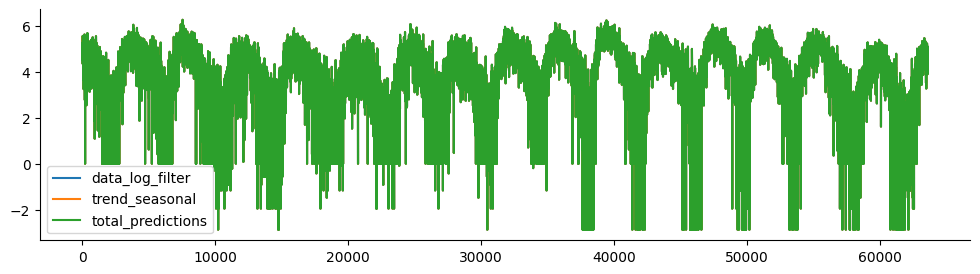

In [781]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train_target[['data_log_filter','trend_seasonal','total_predictions']].plot(legend=True)
sns.despine()

In [782]:
X_trend.shape

(63623, 3)

In [783]:
r2_ts = round(trend_model.score(X_trend[10:],y_trend[10:]),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.299969


In [784]:
y_trend

0        5.494119
1        5.309116
2        5.105599
3        4.861583
4        4.838094
           ...   
63618    4.605741
63619    4.616251
63620    4.540860
63621    4.443659
63622    4.288108
Name: data_log_filter, Length: 63623, dtype: float64

In [785]:
from sklearn.metrics import r2_score

r2_tot = round(r2_score(y_trend[p:],train_target['total_predictions'][p:]),6)
print(f"r2_score: {r2_tot}")

r2_score: 1.0


In [786]:
# stop

Forecasts (TEST)

In [787]:
test.head()

,counts
63623,84
63624,81
63625,70
63626,53
63627,63


In [788]:
df.shape

(63620, 5)

In [789]:
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

In [790]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 63623 to 63672
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   counts    50 non-null     int64
 1   timestep  50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes


In [791]:
test['data_filter'] = savgol_filter(test['counts'], 5, 2) # window size 51, polynomial order 3

test['data_log_filter'] = np.log1p(test['data_filter'])
test['data_log_filter']= test['data_log_filter'].fillna(0)

In [792]:
# test['timestep'] = list(train.shape[0]:test.shape))
test['year_timestep'] = (test['timestep']//365)
test['sc_daytimestep'] = (test['timestep']//4015)


X_test_trend = test[['timestep','year_timestep','sc_daytimestep']]
y_test_trend = test['data_log_filter']

In [793]:
test['trend_model'] = trend_model.predict(X_test_trend)

In [794]:
test[['data_log_filter','trend_model']].head()

,data_log_filter,trend_model
63623,4.477986,4.858185
63624,4.340833,4.860061
63625,4.224537,4.861932
63626,4.078505,4.863800
63627,4.076568,4.865662


In [795]:
def forecast_remainder(*lags):
    """
    spits out forecasted remainder for test data,
    given initial lagged variables
    """
    predicted_remainders = []
    lag_values = list(lags)
    
    for i in range(test.shape[0]):
        
        # row of lagged features
        X = [lag_values]
        
        # predict remainder
        remainder = ar_model.predict(X)[0]
        
        # append remainded
        predicted_remainders.append(remainder)
        
        # lag values for next step
        lag_values = [remainder] + lag_values[:-1]
        
    return predicted_remainders

In [796]:
train['remainder'].tail()

63618    1.989172e-07
63619    1.989152e-07
63620    1.989152e-07
63621    1.989149e-07
63622    1.989118e-07
Name: remainder, dtype: float64

In [797]:
lags = [train.iloc[-1]['remainder'] 
,train.iloc[-2]['remainder'] 
 , train.iloc[-3]['remainder']] 
# , train.iloc[-4]['remainder'] 
# , train.iloc[-5]['remainder'] 
# , train.iloc[-6]['remainder'] 
# , train.iloc[-7]['remainder'] 
# , train.iloc[-8]['remainder'] 
# , train.iloc[-9]['remainder'] 
# , train.iloc[-10]['remainder'] ]
# lag1 = train.iloc[-1]['remainder'] 
# lag1
# lag10


In [798]:
lags

[1.9891178038022872e-07, 1.9891489788648187e-07, 1.9891521318982086e-07]

In [799]:
# train[-1:]
len(forecast_remainder(*lags))

50

In [800]:
test['total_pred'] = test['trend_model'] + forecast_remainder(*lags)
test['total_pred']

63623    4.858185
63624    4.860061
63625    4.861933
63626    4.863800
63627    4.865663
63628    4.867521
63629    4.869375
63630    4.871225
63631    4.873070
63632    4.874911
63633    4.876748
63634    4.878580
63635    4.880408
63636    4.882232
63637    4.884051
63638    4.885866
63639    4.887676
63640    4.889482
63641    4.891284
63642    4.893081
63643    4.894874
63644    4.896663
63645    4.898447
63646    4.900227
63647    4.902002
63648    4.903773
63649    4.905540
63650    4.907302
63651    4.909060
63652    4.910814
63653    4.912563
63654    4.914308
63655    4.916049
63656    4.917785
63657    4.919517
63658    4.921244
63659    4.922967
63660    4.924686
63661    4.926400
63662    4.928110
63663    4.929816
63664    4.931517
63665    4.933214
63666    4.934906
63667    4.936594
63668    4.938278
63669    4.939957
63670    4.941632
63671    4.943303
63672    4.944969
Name: total_pred, dtype: float64

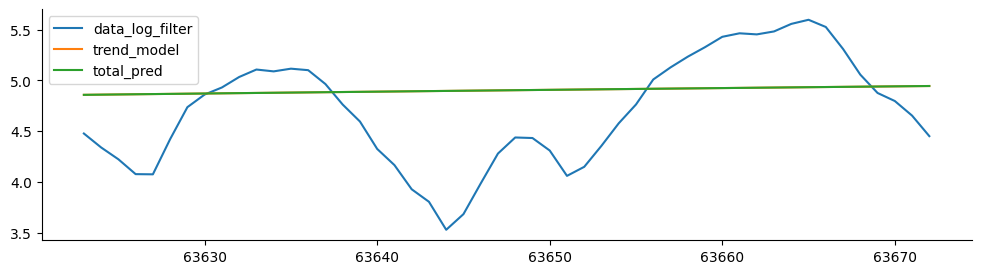

In [801]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test[['data_log_filter','trend_model','total_pred']].plot(legend=True)
sns.despine()

In [802]:
r2_ts = round(trend_model.score(X_test_trend,y_test_trend),6)
print(f"r2_score: {r2_ts}")

r2_score: -0.104522


In [803]:
r2_tot = round(r2_score(y_test_trend,test['total_pred']),6)
print(f"r2_score: {r2_tot}")

r2_score: -0.104522


Checking  ARMA from ARIMA 

In [804]:
# !pip install pmdarima

In [805]:
import pmdarima as pm

In [807]:
Stop

NameError: name 'Stop' is not defined

Running too long....

In [806]:
arima_model = pm.auto_arima(
    df_remainder['remainder'], 
    start_p=0,
    max_p=5,
    d=0,
    seasonal = True,
    stepwise=True,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1347023.238, Time=8.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=14.82 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1346874.305, Time=1.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1370371.351, Time=12.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1370430.314, Time=25.30 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1348022.402, Time=12.68 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1370488.849, Time=29.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=17.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1348020.404, Time=13.41 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-1370547.975, Time=38.78 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=11.75 sec


KeyboardInterrupt: 

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 458.079 seconds

To findout how many lags to use by function.

In [ ]:
# from statsmodels.tsa.ar_model import ar_select_order
# mod = ar_select_order(df_remainder['remainder'], maxlag=200)
# mod.ar_lags

The above function says i need to use 53 lags - So confused here. 